In [4]:
!git clone https://stefan-matcovici/language-detection.git
!pip install -r language-detection/requirements.txt

Cloning into 'language-detection'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 61 (delta 23), reused 41 (delta 9), pack-reused 0
Unpacking objects: 100% (61/61), done.
Branch 'cookiecutter' set up to track remote branch 'cookiecutter' from 'origin'.
Switched to a new branch 'cookiecutter'


In [5]:
!cd language-detection; chmod u+x scripts/download_wili2018.sh; ./scripts/download_wili2018.sh

--2021-04-11 18:25:54--  https://zenodo.org/record/841984/files/wili-2018.zip
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 62403646 (60M) [application/octet-stream]
Saving to: ‘wili-2018.zip’

wili-2018.zip       100%[===================>]  59.51M  3.70MB/s    in 11s     

2021-04-11 18:26:06 (5.39 MB/s) - ‘wili-2018.zip’ saved [62403646/62403646]

Archive:  wili-2018.zip
  inflating: ./data/wili-2018/x_train.txt  
  inflating: ./data/wili-2018/y_train.txt  
  inflating: ./data/wili-2018/x_test.txt  
  inflating: ./data/wili-2018/y_test.txt  
  inflating: ./data/wili-2018/labels.csv  
  inflating: ./data/wili-2018/README.txt  
  inflating: ./data/wili-2018/urls.txt  


In [1]:
import sys
sys.path.append('/content/language-detection/src')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import torch
from transformers import Trainer, TrainingArguments, DistilBertTokenizer, DistilBertForSequenceClassification
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, plot_confusion_matrix, classification_report
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

from data.wili2018_dataset import Wili2018Dataset
from data.wili2018_transformer_dataset import Wili2018TransformerDataset

###Data loading

In [4]:
target_languages = ['eng', 'rus', 'fra', 'spa', 'deu', 'ita', 'nld', 'jpn', 'ara', 'hin', 'urd', 'por', 'fas', 'kor', 'est', 'ron', 'swe', 'tha']
wili2018 = Wili2018Dataset(target_languages)
X_train, Y_train, X_test, Y_test = wili2018.get_data()

###Model and tokenizer loading

In [5]:
model_name = 'distilbert-base-multilingual-cased'
tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels=len(set(Y_train)))

train_dataset = Wili2018TransformerDataset(tokenizer, X_train, Y_train)
test_dataset = Wili2018TransformerDataset(tokenizer, X_test, Y_test)

Some weights of the model checkpoint at distilbert-base-multilingual-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['pre_classifier.weight', 'pre_cla

###Train

In [7]:
training_args = TrainingArguments(
    output_dir=f'/content/language-detection/models/{model_name}',
    num_train_epochs=3, 
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=50,   
    weight_decay=0.01,    
    logging_dir='./logs',    
    logging_steps=25,
    save_steps=200
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

Step,Training Loss
25,2.850200
50,2.076100
75,0.538200
100,0.189600
125,0.100000
150,0.085800
175,0.055400
200,0.065400
225,0.083300
250,0.024600


TrainOutput(global_step=846, training_loss=0.19754036593451285, metrics={'train_runtime': 778.0548, 'train_samples_per_second': 1.087, 'total_flos': 1.1225517705216e+16, 'epoch': 3.0, 'init_mem_cpu_alloc_delta': 1629872128, 'init_mem_gpu_alloc_delta': 541632000, 'init_mem_cpu_peaked_delta': 0, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 211415040, 'train_mem_gpu_alloc_delta': 1635186176, 'train_mem_cpu_peaked_delta': 173899776, 'train_mem_gpu_peaked_delta': 13072372736})

###Load best model and predict test set

In [8]:
model = DistilBertForSequenceClassification.from_pretrained(f'/content/language-detection/models/{model_name}/checkpoint-800')
model.to('cuda')

trainer.model = model
prediction_result = trainer.predict(test_dataset)

y_pred = np.argmax(prediction_result.predictions, axis=1).tolist()
y_pred = LabelEncoder().fit(Y_train).inverse_transform(y_pred)

###Classification report

In [9]:
print(classification_report(Y_test, y_pred, zero_division=0, digits=4))

              precision    recall  f1-score   support

         ara     1.0000    0.9960    0.9980       500
         deu     0.9940    0.9880    0.9910       500
         eng     0.9686    0.9860    0.9772       500
         est     0.9920    0.9920    0.9920       500
         fas     1.0000    0.9980    0.9990       500
         fra     0.9960    0.9980    0.9970       500
         hin     0.9880    0.9880    0.9880       500
         ita     0.9901    0.9980    0.9940       500
         jpn     1.0000    0.9960    0.9980       500
         kor     0.9980    1.0000    0.9990       500
         nld     0.9960    0.9960    0.9960       500
         por     0.9940    0.9880    0.9910       500
         ron     0.9901    0.9960    0.9930       500
         rus     0.9862    1.0000    0.9930       500
         spa     0.9980    0.9880    0.9930       500
         swe     1.0000    1.0000    1.0000       500
         tha     1.0000    0.9860    0.9930       500
         urd     1.0000    

###Confusion matrix

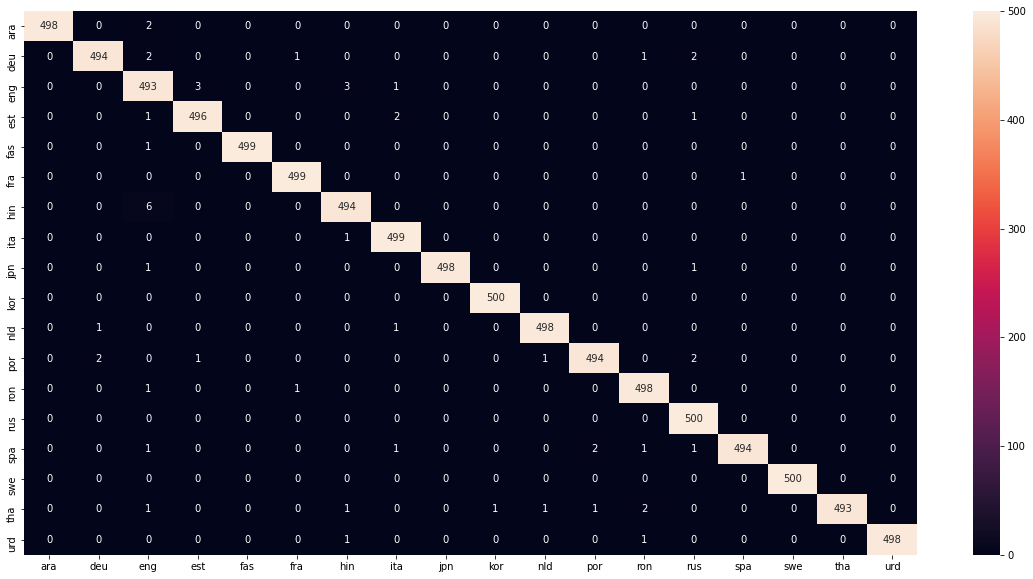

In [10]:
label_list = sorted(list(set(y_pred)))
cm = confusion_matrix(Y_test, y_pred, label_list)

plt.figure(figsize = (20, 10))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_list, yticklabels=label_list)